
![ImageName](pic/title.jpg)  

**作者：[lqy](https://www.heywhale.com/home/user/profile/5f27fd9633e1be002cc65a1d)** 华东师范大学气象学研究生、和鲸社区气象数据科学频道版主

🐋：本项目来自和鲸社区《[气象训练营⑦：WRF模式后处理](https://www.heywhale.com/home/competition/64478fec113e81a18dc70cd1)》活动，所有教案代码都可以一键跑通，你可以 fork 后在线在线运行、调试学习、完成作业练习。  

学习过程中如果你遇到任何问题，欢迎使用搜索引擎，或在 [讨论区](https://www.heywhale.com/home/competition/forumlist/64478fec113e81a18dc70cd1) 中发帖提出，我们很乐意为你提供帮助。

# 关卡七：绘制WRF模拟的剖面图

剖面图又可以称为截面图，就是用一个截面去查看高维的气象数据，**能够帮助我们更清晰得认识天气系统的高度变化、水平分布、时间演变等信息**，在气象业务和科研中是非常受欢迎的一种绘图形式。  

**WRF模式数据投影并不一定是标准经纬网格，因此也需要用到上一关中的插值方法**，这里我们通过一个具体例子来看看插值函数如何实现剖面图的绘制。

> 官网示例：https://wrf-python.readthedocs.io/en/latest/plot.html  


![Image Name](pic/touying.png)  

尽管剖面图有很多形式，例如：**纬度-高度图、经度-高度图、时间-高度图**等等，而我们只需掌握其中一种，再绘制其他形式的剖面图自然就不是难事了。  


## 导入模块

In [1]:
# 一次性导入所有模块
from scipy import interpolate
import metpy.calc as mpcalc  
from metpy.units import units  
import xarray as xr 
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords, vertcross, cartopy_xlim, cartopy_ylim, interpline, CoordPair

## 读取数据

为了绘制**垂直剖面图**，我们通常需要获取**高度数据**，并结合感兴趣的变量进行分析，此处选择了**地形和基本反射率**作为例子。

In [4]:
# WRF数据目录
wrfout_path = './dataset/wrfout/'
# 基于 netcdf 读取 WRF 模拟数据
wrf_file = Dataset(wrfout_path + 'wrfout_d01_2019-08-09_06_00_00')

In [5]:
# 获取 WRF 模拟变量
ht = getvar(wrf_file, "z", timeidx=-1)
ter = getvar(wrf_file, "ter", timeidx=-1)
dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) 

## 绘制基本反射率叠加地形的剖面图

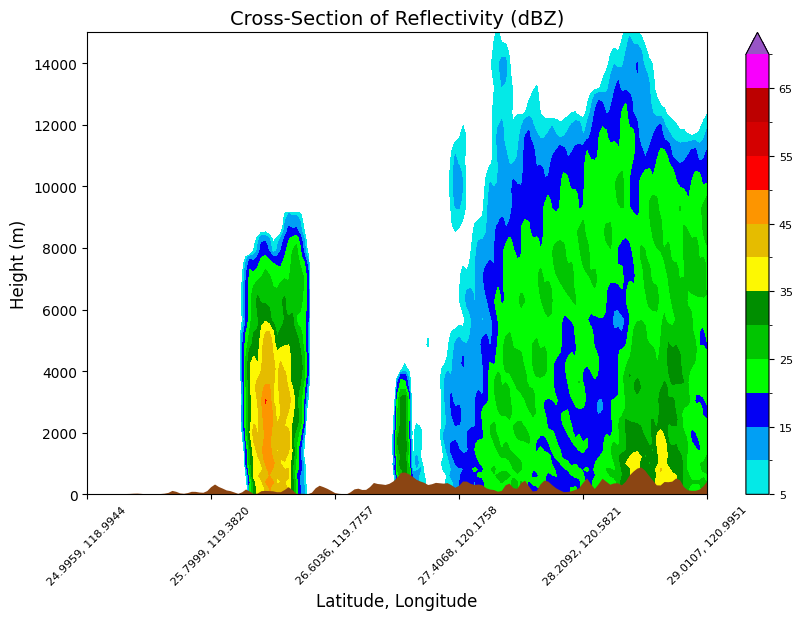

In [6]:
# 定义起点（119°E，25°N）和终点（121°E，29°N）
cross_start = CoordPair(lat=25, lon=119)
cross_end = CoordPair(lat=29, lon=121)

# 根据定义起点（119°E，25°N）和终点（121°E，29°N），进行垂直方向上的插值
z_cross = vertcross(Z, ht, wrfin=wrf_file,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, meta=True)

# 转换为dbz
dbz_cross = 10.0 * np.log10(z_cross)

# 为dbz添加属性
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

# 转为numpy数组
dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

# 缺失值填充
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]

# 获取地形高度
ter_line = interpline(ter, wrfin=wrf_file, start_point=cross_start, end_point=cross_end)

# 获取经纬度
lats, lons = latlon_coords(dbz)

# 获取投影信息
cart_proj = get_cartopy(dbz)

# 创建画布
fig = pyplot.figure(figsize=(10,6))
ax_cross = pyplot.axes()

# 设置基本反射率的绘图间隔
dbz_levels = np.arange(5., 75., 5.)

# 自定义基本反射率的colorbar
dbz_rgb = np.array([[4,233,231],[1,159,244], [3,0,244], [2,253,2], [1,197,1],
                    [0,142,0],  [253,248,2], [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0], [188,0,0],[248,0,253], [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb, extend="max")

# 绘制基本反射率dbz的垂直剖面图（用contourf实现等值线填充）
dbz_levels = np.arange(5.,75.,5.)
xs = np.arange(0, dbz_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
dbz_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 levels=dbz_levels,
                                 cmap=dbz_map,
                                 norm=dbz_norm,
                                 extend="max")
# 添加colorbar
cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross)
cb_dbz.ax.tick_params(labelsize=8)

# 对地形进行填充
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line), facecolor="saddlebrown")

# 经纬度转为numpy数组
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# 设置x轴刻度显示
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# 设置x轴和y轴标签
ax_cross.set_xlabel("Latitude, Longitude", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

# 设置y轴显示范围
ax_cross.set_ylim(0, 15000)

# 添加标题
ax_cross.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

pyplot.show()

通过基本反射率的垂直剖面图，**我们可以更直观地看到对流活动的垂直发展**。此处，我们叠加了地形高度，可以来分析强降雨是否受到地形抬升的作用。  

当然，我们还可以添加其他有关变量，例如风速、相对湿度等等，让剖面图内容更加丰富。  

恭喜你完成了WRF后处理训练营第七关的学习材料~~

### ✍小练习：绘制风速剖面图

绘制台风利奇马**风速剖面图**，可以得到 WRF 模式对台风**风场结构的三维模拟**。

In [5]:
### （你的代码）###



## 闯关题  

### STEP1：根据要求完成题目：  



绘制X点（25°N，121°E）到Y点（29°N，124°E）的截面图（西南-东北走向）,  

1. 台风利奇马的基本反射率大值区位于？  
A. 西南侧  
B. 东北侧  

2. 台风利奇马的风速大值区位于？  
A. 西南侧  
B. 东北侧  

In [ ]:
# 填入你的答案
answer_1 = ''
answer_2 = ''

## ⚡ 下一关预告：  

恭喜已经学完所有的教案材料，接下来就是通关题——《评估台风利奇马的路径和强度的模拟》，祝顺利通关~